# Setup

## Imports & Settings

In [1]:
%load_ext autoreload
%autoreload 2

import os
import re
import scanpy as sc
import pandas as pd
import numpy as np
import corescpy as cr

# Computing Resources
gpu = False
sc.settings.n_jobs = 4
sc.settings.max_memory = 150

# Display
pd.options.display.max_columns = 100
pd.options.display.max_rows = 500
sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(20, 20))

# Column Names (from Metadata & To Be Created)
col_sample_id_o, col_sample_id = "Sample ID", "Sample"  # in metadata, new
col_subject = "Patient"  # in metadata file
col_inflamed, col_stricture = "Inflamed", "Stricture"  # in metadata file
col_condition = "Condition"  # constructed from col_inflamed & col_stricture
col_fff = "file_path"  # column in metadata in which to store data file path
col_cell_type = "Annotation"  # for eventual cluster annotation column
col_tangram = "tangram_prediction"  # for future Tangram imputation annotation

ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

## Options & Data

In [2]:
# Directories & Metadata
load, reannotate = False, True
run = "CHO-007"
# run = ["CHO-001", "CHO-002"]
# run = ["CHO-001", "CHO-002", "CHO-005", "CHO-006", "CHO-007"]
samples = "all"
# samples = ["50564A4", "50618B5"]
# samples = ["50007B2"]
# samples = ["50452A", "50452B", "50452C"]
# samples = ["50564A4", "50618B5"]

# Optionally, Define Manual Annotation Version
# should be stored in ("<out_dir>/annotations_dictionaries")
# in format <selves[i]._library_id>___leiden_<resc[i]>_dictionary.xlsx
# with first column = leiden cluster and second column = annotation
resc = None
# resc = ["res1pt5_dist0_npc30", "res1pt5_dist0_npc30",
#         "res0pt75_dist0pt3_npc30"]

# Main Directories
# Replace manually or mirror my file/directory tree in your home (`ddu`)
ddu = os.path.expanduser("~")
ddm = "/mnt/cho_lab" if os.path.exists("/mnt/cho_lab") else "/mnt"  # Spark?
ddl = f"{ddm}/disk2/{os.getlogin()}/data/shared-xenium-library" if (
    "cho" in ddm) else os.path.join(ddu, "shared-xenium-library")
ddx = f"{ddm}/bbdata1"  # mounted drive Xenium folder
out_dir = os.path.join(ddl, "outputs", "TUQ97N", "nebraska")  # None = no save
d_path = os.path.join(ddm, "disk2" if "cho" in ddm else "",
                      os.getlogin(), "data")  # other, e.g., Tangram data
anf = pd.read_csv(os.path.join(ddu, "corescpy/examples/markers_lineages.csv"))
file_mdf = os.path.join(ddl, "samples.csv")  # metadata

# Annotation & Tangram Imputation
col_assignment = "Bin"  # which column from annotation file to use
# col_cell_type_sc, file_sc = "ClusterAnnotation", str(
#     f"{d_path}/2023-05-12_CombinedCD-v2_ileal_new.h5ad")
col_cell_type_sc, file_sc = "cell_type", f"{d_path}/elmentaite_ileal.h5ad"
# file_sc = None  # to skip Tangram imputation/label transfer

# Processing & Clustering Options
kws_pp = dict(cell_filter_pmt=None, cell_filter_ncounts=[50, None],
              cell_filter_ngene=[10, None], gene_filter_ncell=[3, None],
              gene_filter_ncounts=[3, None], custom_thresholds=None,
              kws_scale=dict(max_value=10, zero_center=True),
              method_norm="log")  # preprocessing keyword arguments
kws_cluster = dict(kws_umap=dict(method="rapids" if gpu else "umap"),
                   genes_subset=list(anf.iloc[:, 0]),  # use only markers
                   use_gpu=gpu, use_highly_variable=False)
kws_clustering, col_assignment = {}, []
for i in zip([0.5, 0.75, 1.5], [0.5, 0.3, 0], [30, 30, 30]):
    kws = {**kws_cluster, "resolution": i[0], "kws_umap": {
        **kws_cluster["kws_umap"], "min_dist": i[1]}, "n_comps": i[2]}
    suff = str(f"res{re.sub('[.]', 'pt', str(kws['resolution']))}_dist"
               f"{re.sub('[.]', 'pt', str(kws['kws_umap']['min_dist']))}"
               f"_npc{kws['n_comps']}")  # file path suffix
    kws_clustering.update({suff: kws})
    col_assignment += ["group" if kws["resolution"] >= 0.7 else "Bucket"]

# After this point, no more options to specify
# Just code to infer the data file path from your specifications
# and construct argument dictionaries and manipulate metadata and such.

# Read Metadata & Other Information
metadata = (pd.read_excel if file_mdf[-4:] == "xlsx" else pd.read_csv)(
    file_mdf, dtype={"Slide ID": str}).rename({
        "Name": col_subject, "Inflammation": col_inflamed}, axis=1)
if samples not in ["all", None]:  # subset by sample ID?
    metadata = metadata.set_index(col_sample_id_o).loc[samples].reset_index()

# Revise Metadata & Construct Variables from Options
metadata.loc[:, col_condition] = metadata.apply(lambda x: "Stricture" if x[
    col_stricture].lower() in ["stricture", "yes"] else x[
        col_inflamed].capitalize(), axis=1)  # inflamation/stricture condition
metadata.loc[:, col_sample_id] = metadata[[col_condition, col_sample_id_o]
                                          ].apply("-".join, axis=1)
metadata = metadata.set_index(col_sample_id)
fff = np.array(cr.pp.construct_file(run=run, directory=ddx))
bff = np.array([os.path.basename(i) for i in fff])  # base path names
samps = np.array([i.split("__")[2].split("-")[0] for i in fff])
for x in metadata[col_sample_id_o]:
    m_f = metadata[metadata[col_sample_id_o] == x][
        "out_file"].iloc[0]  # ...use to find unconventionally-named files
    locx = np.where(samps == x)[0] if pd.isnull(
        m_f) else np.where(bff == m_f)[0]
    metadata.loc[metadata[col_sample_id_o] == x, col_fff] = fff[locx[0]] if (
        len(locx) > 0) else np.nan  # assign output file to metadata row
metadata = metadata.dropna(subset=[col_fff]).drop_duplicates()

# Annotation File
assign = anf.dropna(subset=col_assignment).set_index(
    "gene").rename_axis("Gene")  # markers
assign = assign[~assign.Quality.isin([-1])]  # drop low-quality markers

# Print Metadata & Make Output Directory (If Not Present)
print(metadata)
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Load Data
kws_init = dict(col_sample_id=col_sample_id, col_subject=col_subject,
                col_cell_type=col_cell_type)  # object creation arguments
selves = [None] * metadata.shape[0]  # to hold different samples
for i, x in enumerate(metadata.index.values):
    selves[i] = cr.Spatial(metadata.loc[x][col_fff], library_id=x, **kws_init)
    for j in metadata:  # iterate metadata columns
        selves[i].rna.obs.loc[:, j] = str(metadata.loc[x][j])  # add to object
    selves[i].rna.obs.loc[:, "out_file"] = os.path.join(
        out_dir, selves[i]._library_id)  # output path (to save object)
    if load is True:
        selves[i].update_from_h5ad(str(selves[i].rna.obs.out_file.iloc[0]))
        print(selves[i].rna)

# Marker Gene Dictionary (for Scanpy Plotting)
marker_genes_dict = dict(assign["Bucket"].reset_index().groupby(
    "Bucket").apply(lambda x: list(pd.unique(list(set(
        x.Gene).intersection(selves[0].rna.var_names))))))  # to dictionary

                  Sample ID  Patient     Status  Slide Id          Project  \
Sample                                                                       
Stricture-50006C     50006C    50006  Available   22406.0  scRNA & Spatial   
Uninflamed-50006B    50006B    50006  Available   22407.0  scRNA & Spatial   
Inflamed-50006A      50006A    50006  Available   22407.0  scRNA & Spatial   

                         Location Stricture  GRID ID    Inflamed  \
Sample                                                             
Stricture-50006C   Terminal Ileum       yes  1011312    inflamed   
Uninflamed-50006B  Terminal Ileum        no  1011312  uninflamed   
Inflamed-50006A    Terminal Ileum        no  1011312    inflamed   

                  Procedure Date  Age     Sex   Race Hispanic  \
Sample                                                          
Stricture-50006C         2023-11   75  female  white       NO   
Uninflamed-50006B        2023-11   75  female  white       NO   
Inflamed

## Manual Annotations

### Load Manual Annotations

In [ ]:
if resc is not None:
    mans = dict(zip([s._library_id for s in selves], [dict(
        pd.read_excel(os.path.join(out_dir, "annotation_dictionaries", str(
            f"{s._library_id}___leiden_{resc[i]}_dictionary.xlsx",
            )), index_col=0).annotation) if resc[
                i] else None for i, s in enumerate(selves)]))
    mans = dict(zip(mans, [dict(zip([str(int(i)) for i in mans[m]], [
        mans[m][i] for i in mans[m]])) for m in mans]))
    for i, s in enumerate(selves):
        if resc[i] is None:
            continue
        s.rna.obs.loc[:, f"manual_{resc[i]}"] = s.rna.obs[
            f"leiden_{resc[i]}"].astype(int).astype(str).replace(
                mans[s._library_id])  # replace Leiden with manual annotations
        s.rna.obs.loc[s.rna.obs[f"manual_{resc[i]}"].isnull(),
                      f"manual_{resc[i]}"] = s.rna.obs.loc[s.rna.obs[
                          f"manual_{resc[i]}"].isnull(
                              ), f"leiden_{resc[i]}"].astype(str)  # NA -> L
        s.rna.obs.loc[:, f"manual_{resc[i]}"] = s.rna.obs[
            f"manual_{resc[i]}"].astype("category")  # as categorical
        s._columns["col_cell_type"] = f"manual_{resc[i]}"
        # s.plot_spatial(f"manual_{resc[i]}")for s in selves:
        s.rna.obs.loc[:, s._columns["col_cell_type"]] = s.rna.obs[s._columns[
            "col_cell_type"]].astype("category")

### Write Manual Annotations

In [ ]:
if resc is not None and out_dir is not None:
    for i, s in enumerate(selves):
        s.write_clusters(out_dir, col_cell_type=f"manual_{resc[i]}",
                         overwrite=True, file_prefix=f"{s._library_id}__")
        s.write(s.rna.obs.out_file.iloc[0])

# Clustering

## Processing, Leiden, Annotation



 {'cell_filter_pmt': None, 'cell_filter_ncounts': [50, None], 'cell_filter_ngene': [10, None], 'gene_filter_ncell': [3, None], 'gene_filter_ncounts': [3, None], 'custom_thresholds': None, 'kws_scale': {'max_value': 10, 'zero_center': True}, 'method_norm': 'log'} 


AnnData object with n_obs × n_vars = 721489 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels', 'Sample', 'Sample ID', 'Patient', 'Status', 'Slide Id', 'Project', 'Location', 'Stricture', 'GRID ID', 'Inflamed', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease_Status', 'Date Collected', 'Date Sectioned', 'Date Hybridization', 'Storage 4c', 'Created By', 'Created', 'Storage Status', 'Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'out_file', 'Condition', 'file_

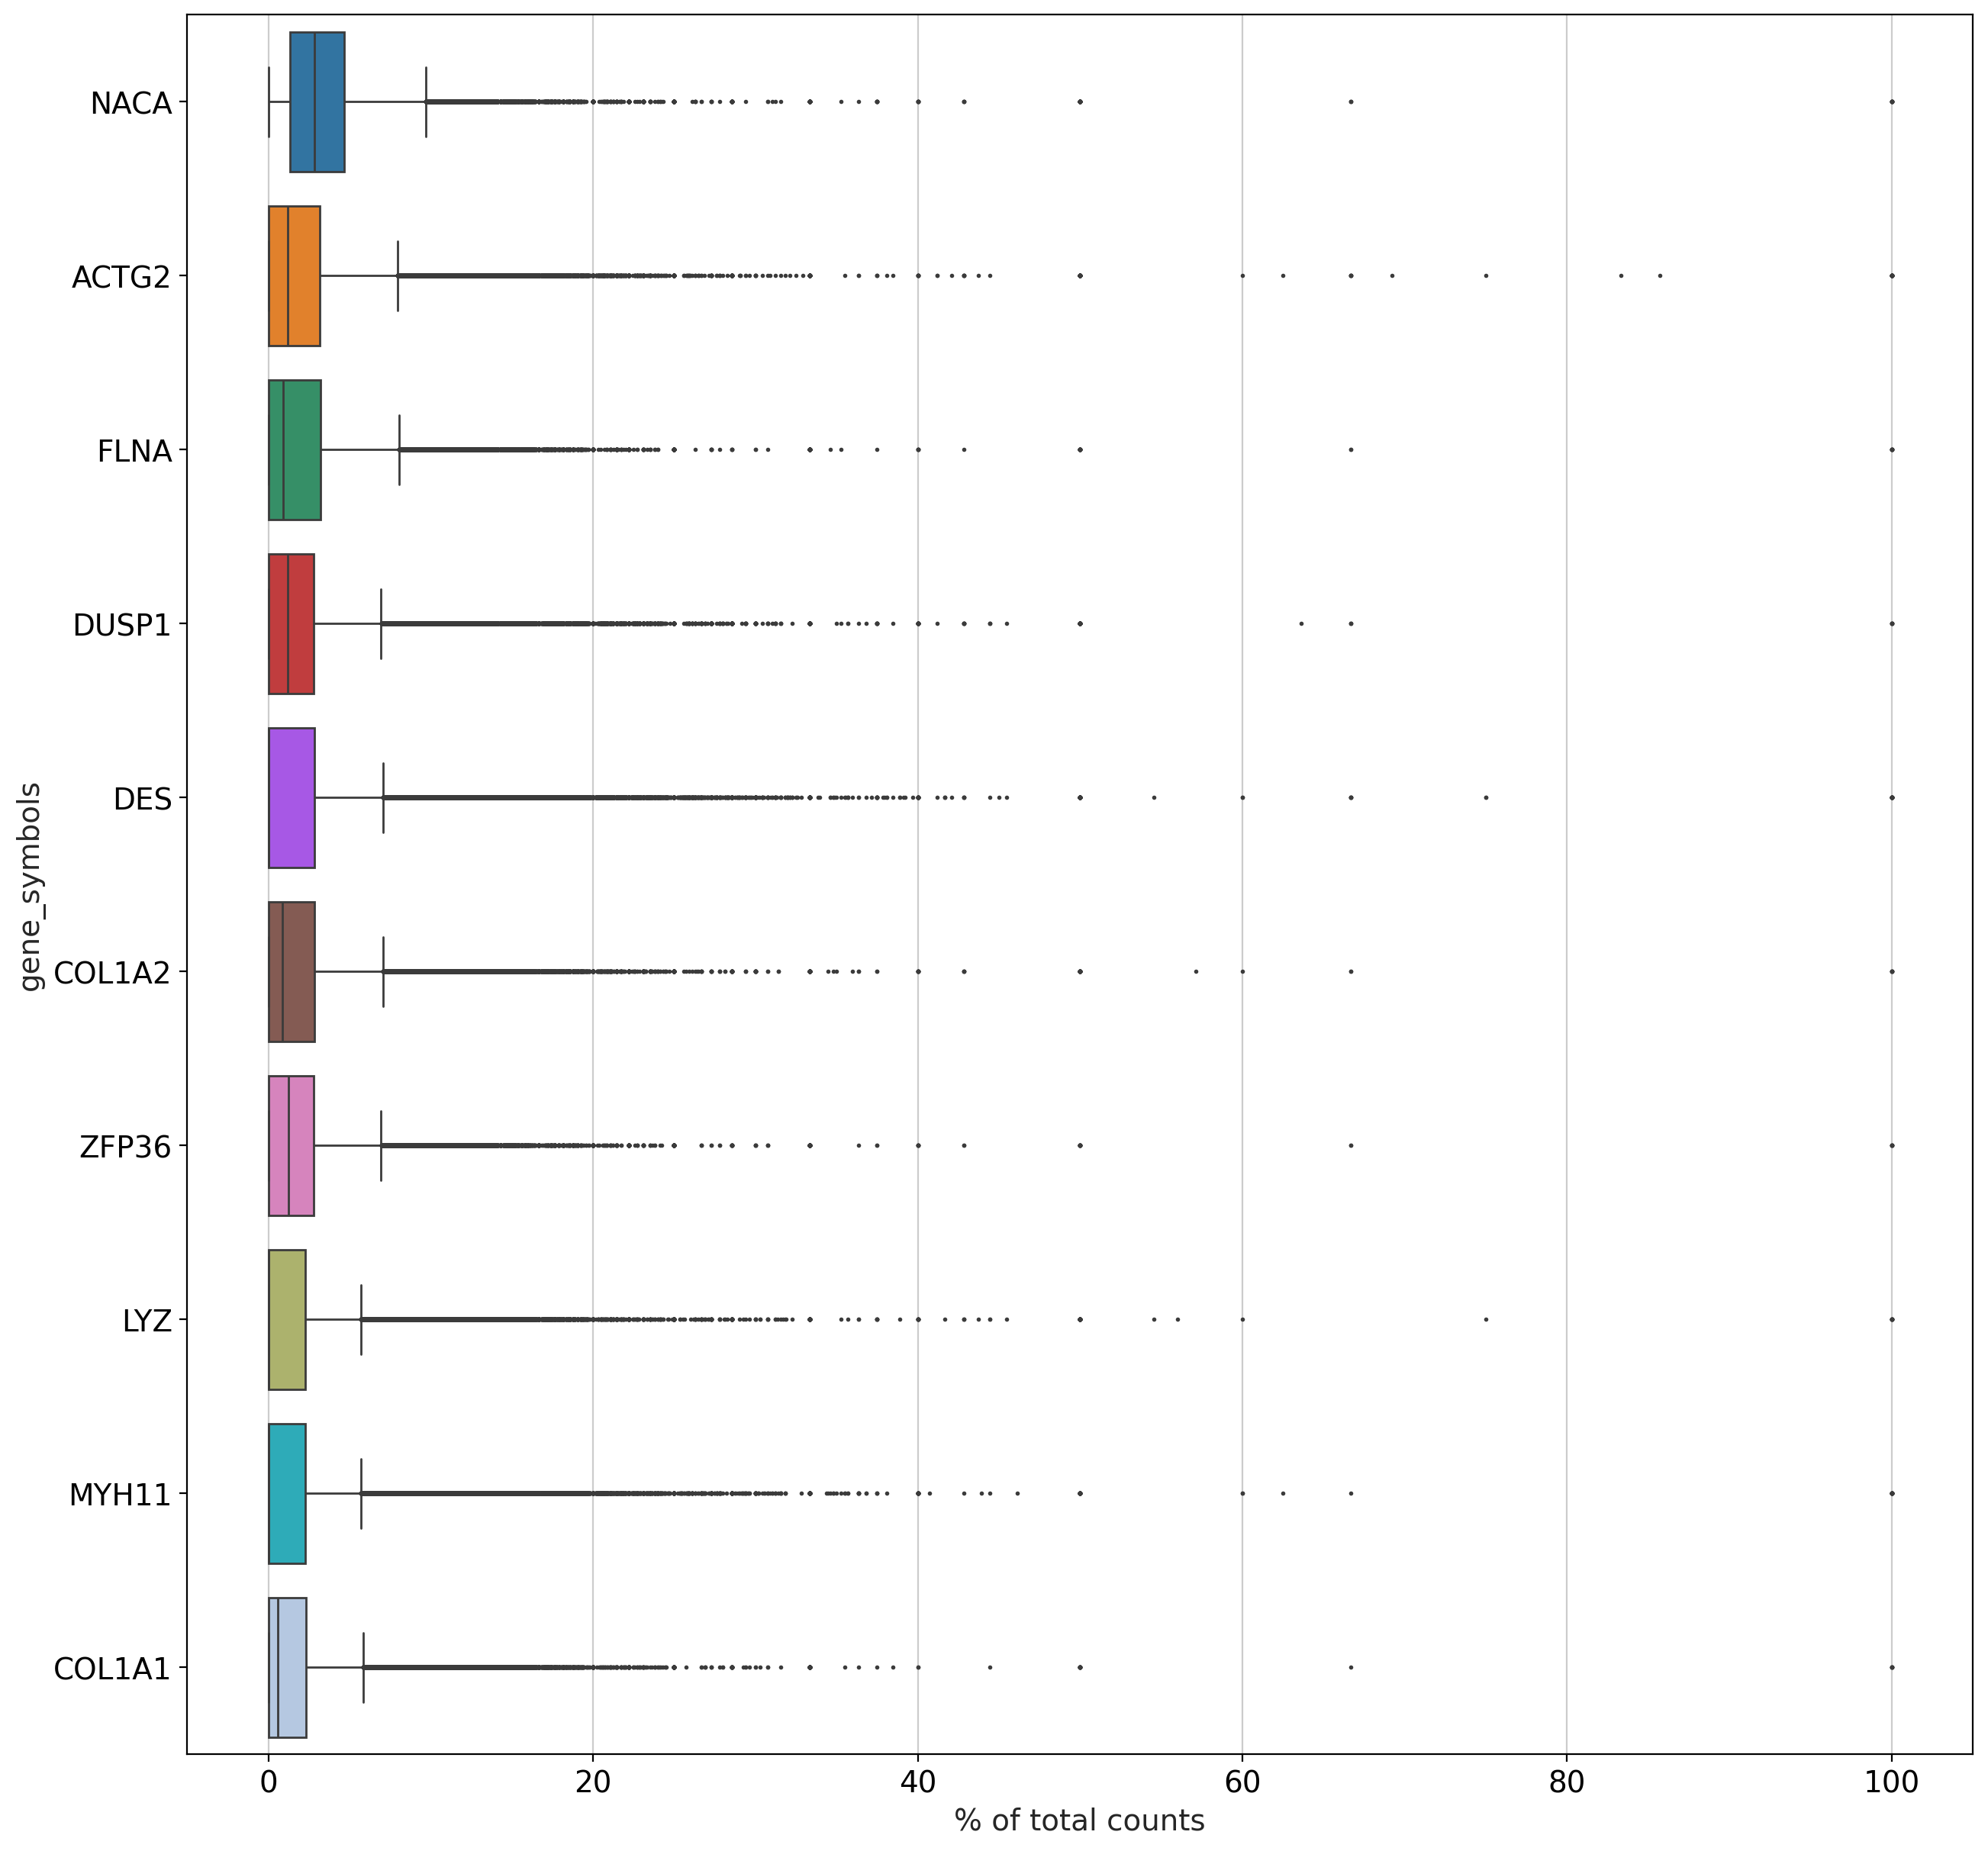

dsfasfda AnnData object with n_obs × n_vars = 721489 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels', 'Sample', 'Sample ID', 'Patient', 'Status', 'Slide Id', 'Project', 'Location', 'Stricture', 'GRID ID', 'Inflamed', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease_Status', 'Date Collected', 'Date Sectioned', 'Date Hybridization', 'Storage 4c', 'Created By', 'Created', 'Storage Status', 'Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'out_file', 'Condition', 'file_path', 'n_counts', 'log_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'spatial', 'original_ix'
    obsm: 'spatial'
    layers: 'counts'


Cell Counts: Initial


Observations: 721489



Gene Counts: Initial

Em

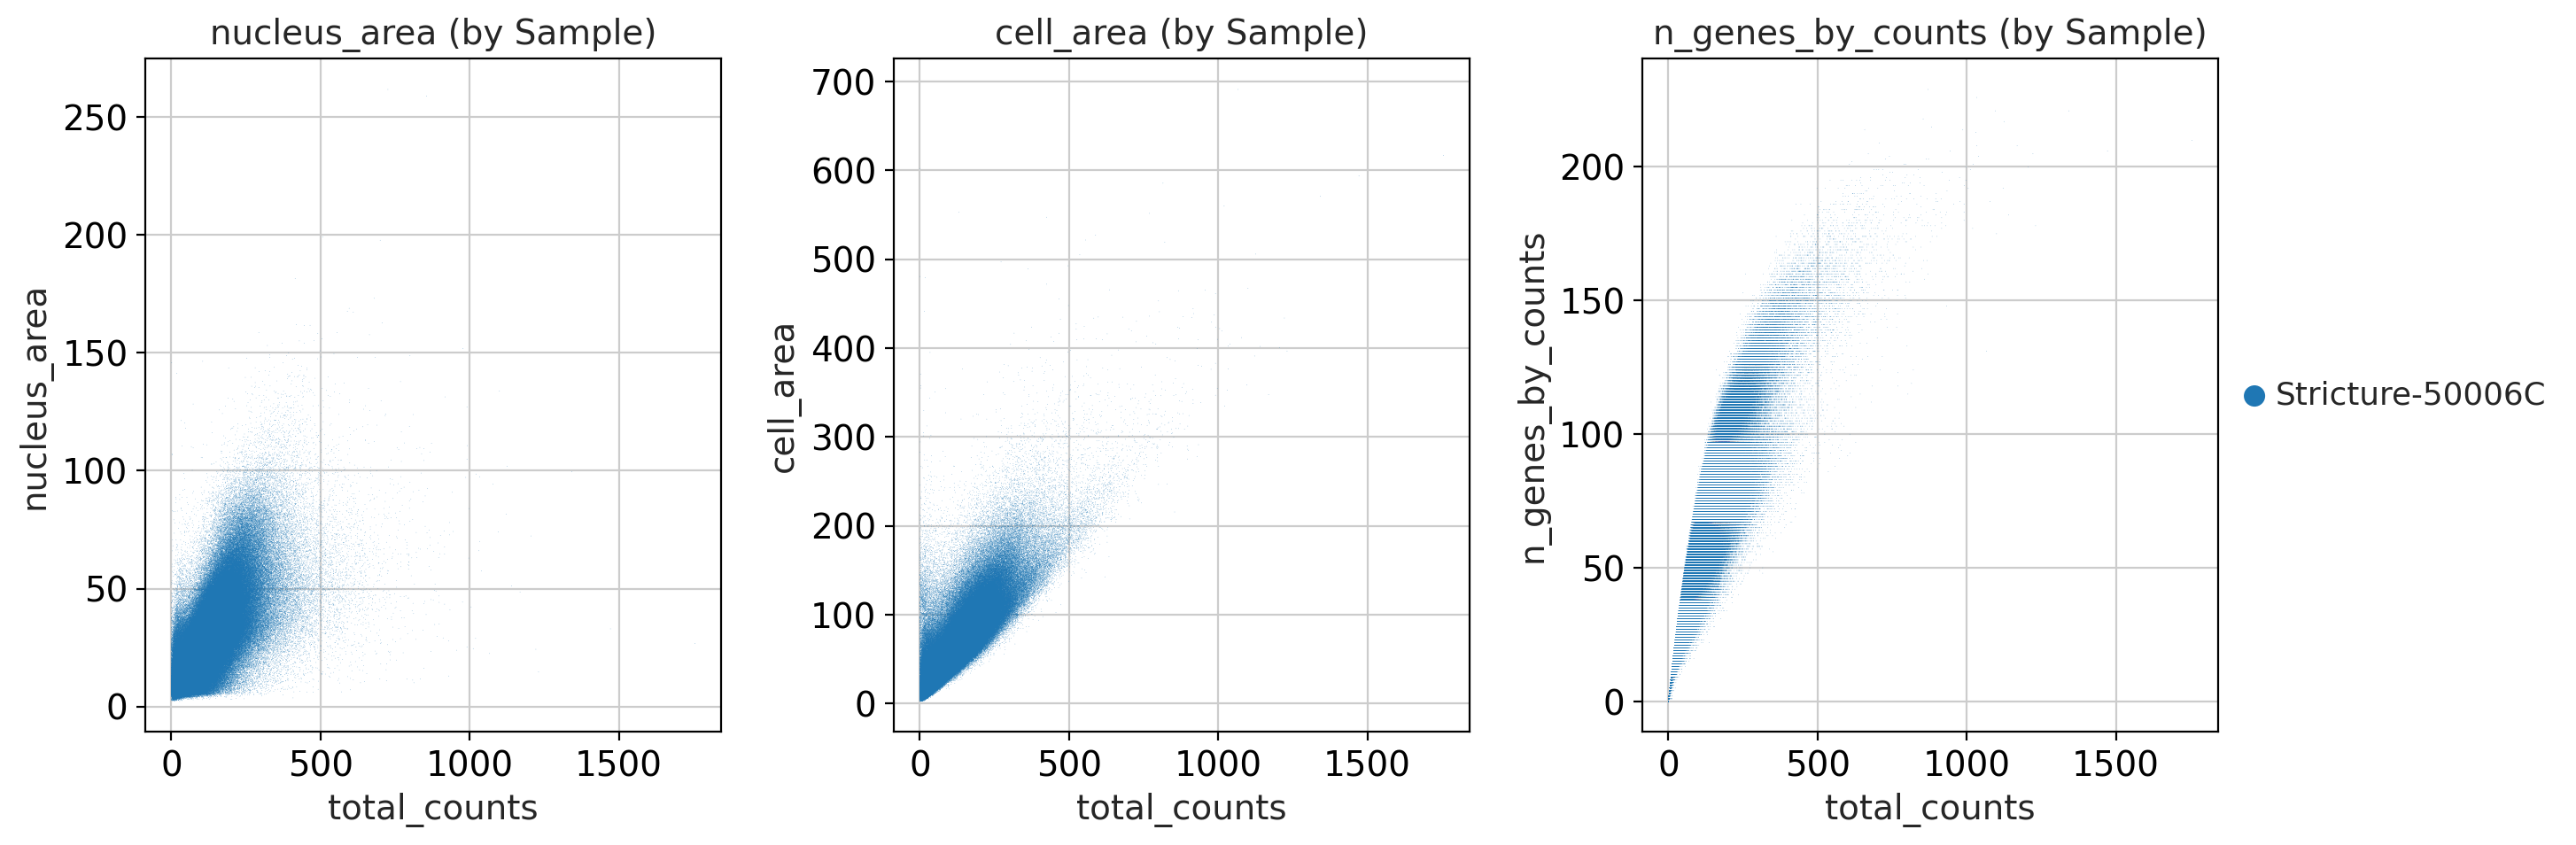


<<< FILTERING CELLS (TOO FEW GENES) & GENES (TOO FEW CELLS) >>>
dsfasfda AnnData object with n_obs × n_vars = 710242 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels', 'Sample', 'Sample ID', 'Patient', 'Status', 'Slide Id', 'Project', 'Location', 'Stricture', 'GRID ID', 'Inflamed', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease_Status', 'Date Collected', 'Date Sectioned', 'Date Hybridization', 'Storage 4c', 'Created By', 'Created', 'Storage Status', 'Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'out_file', 'Condition', 'file_path', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_c

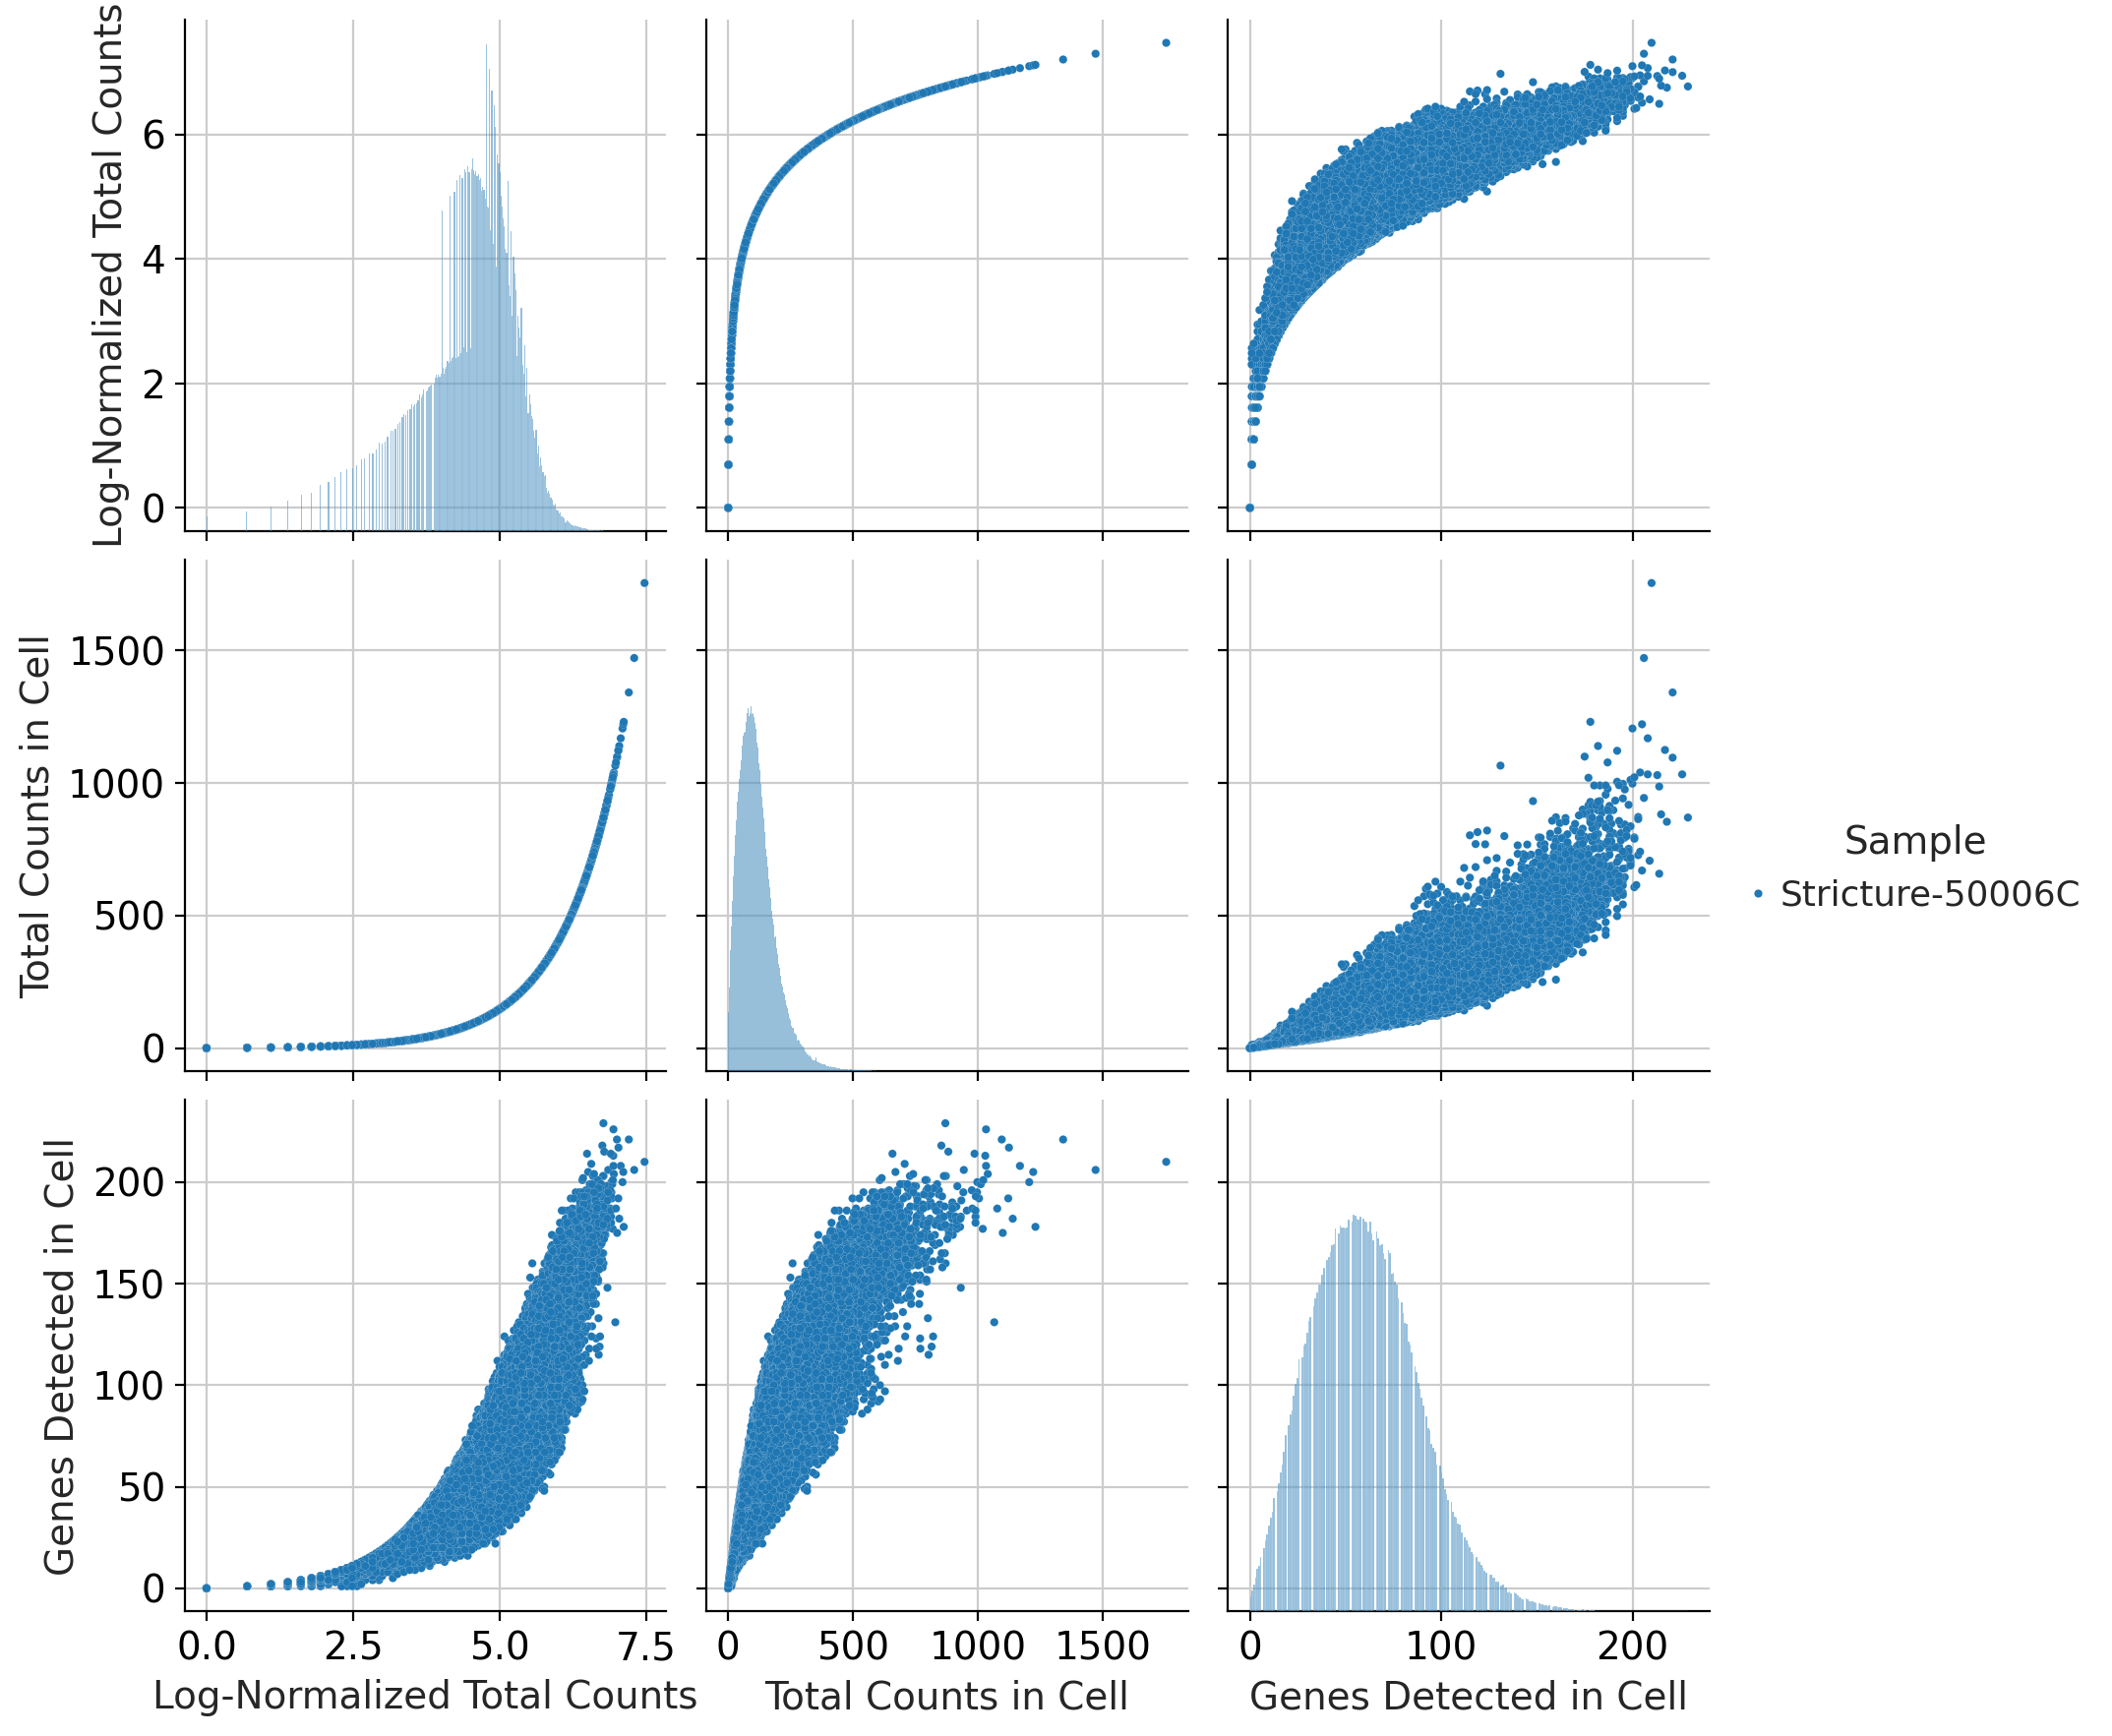

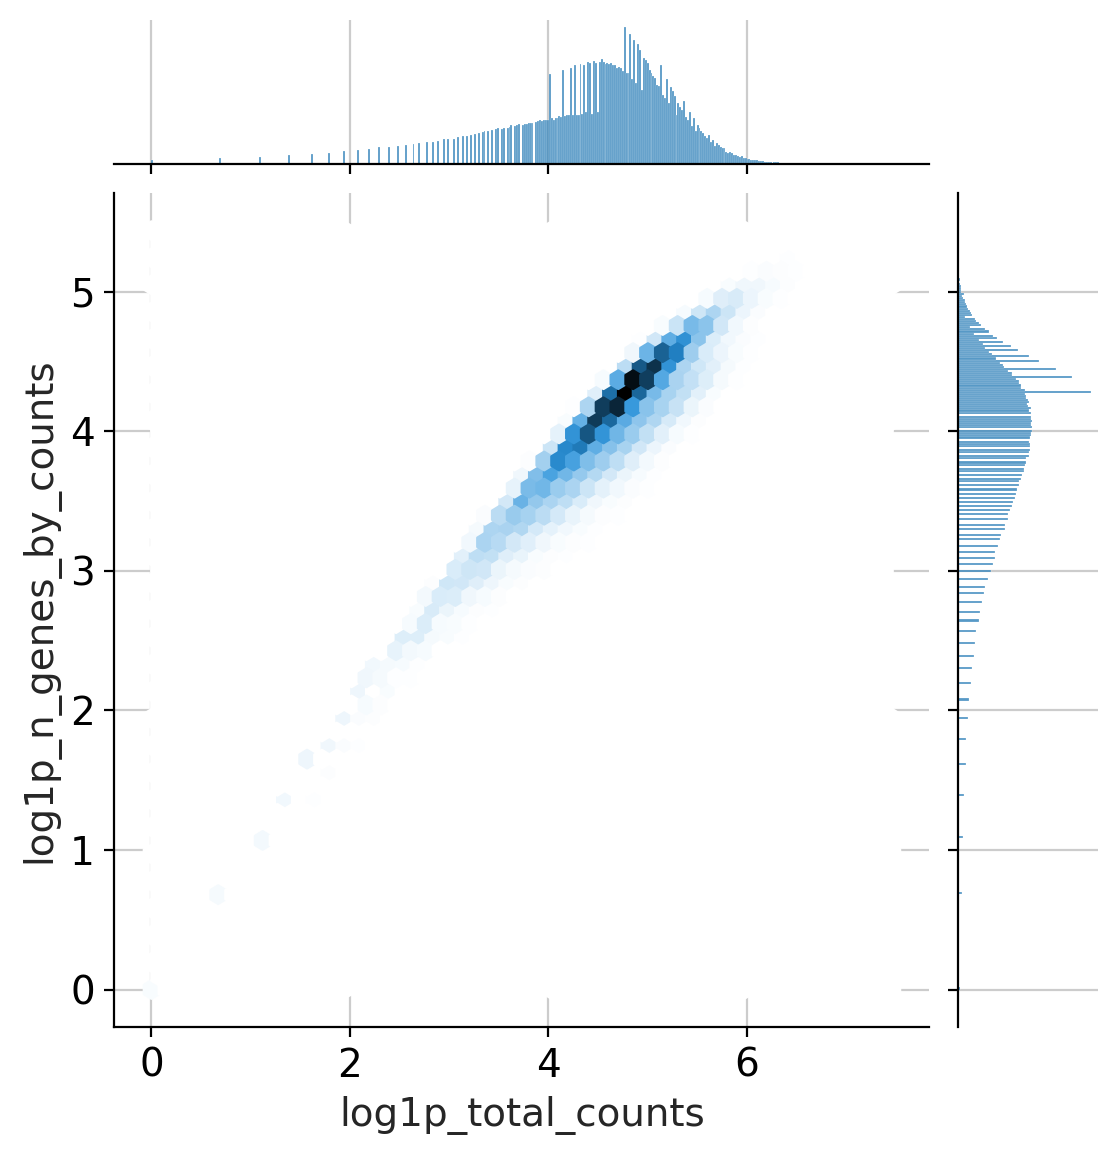

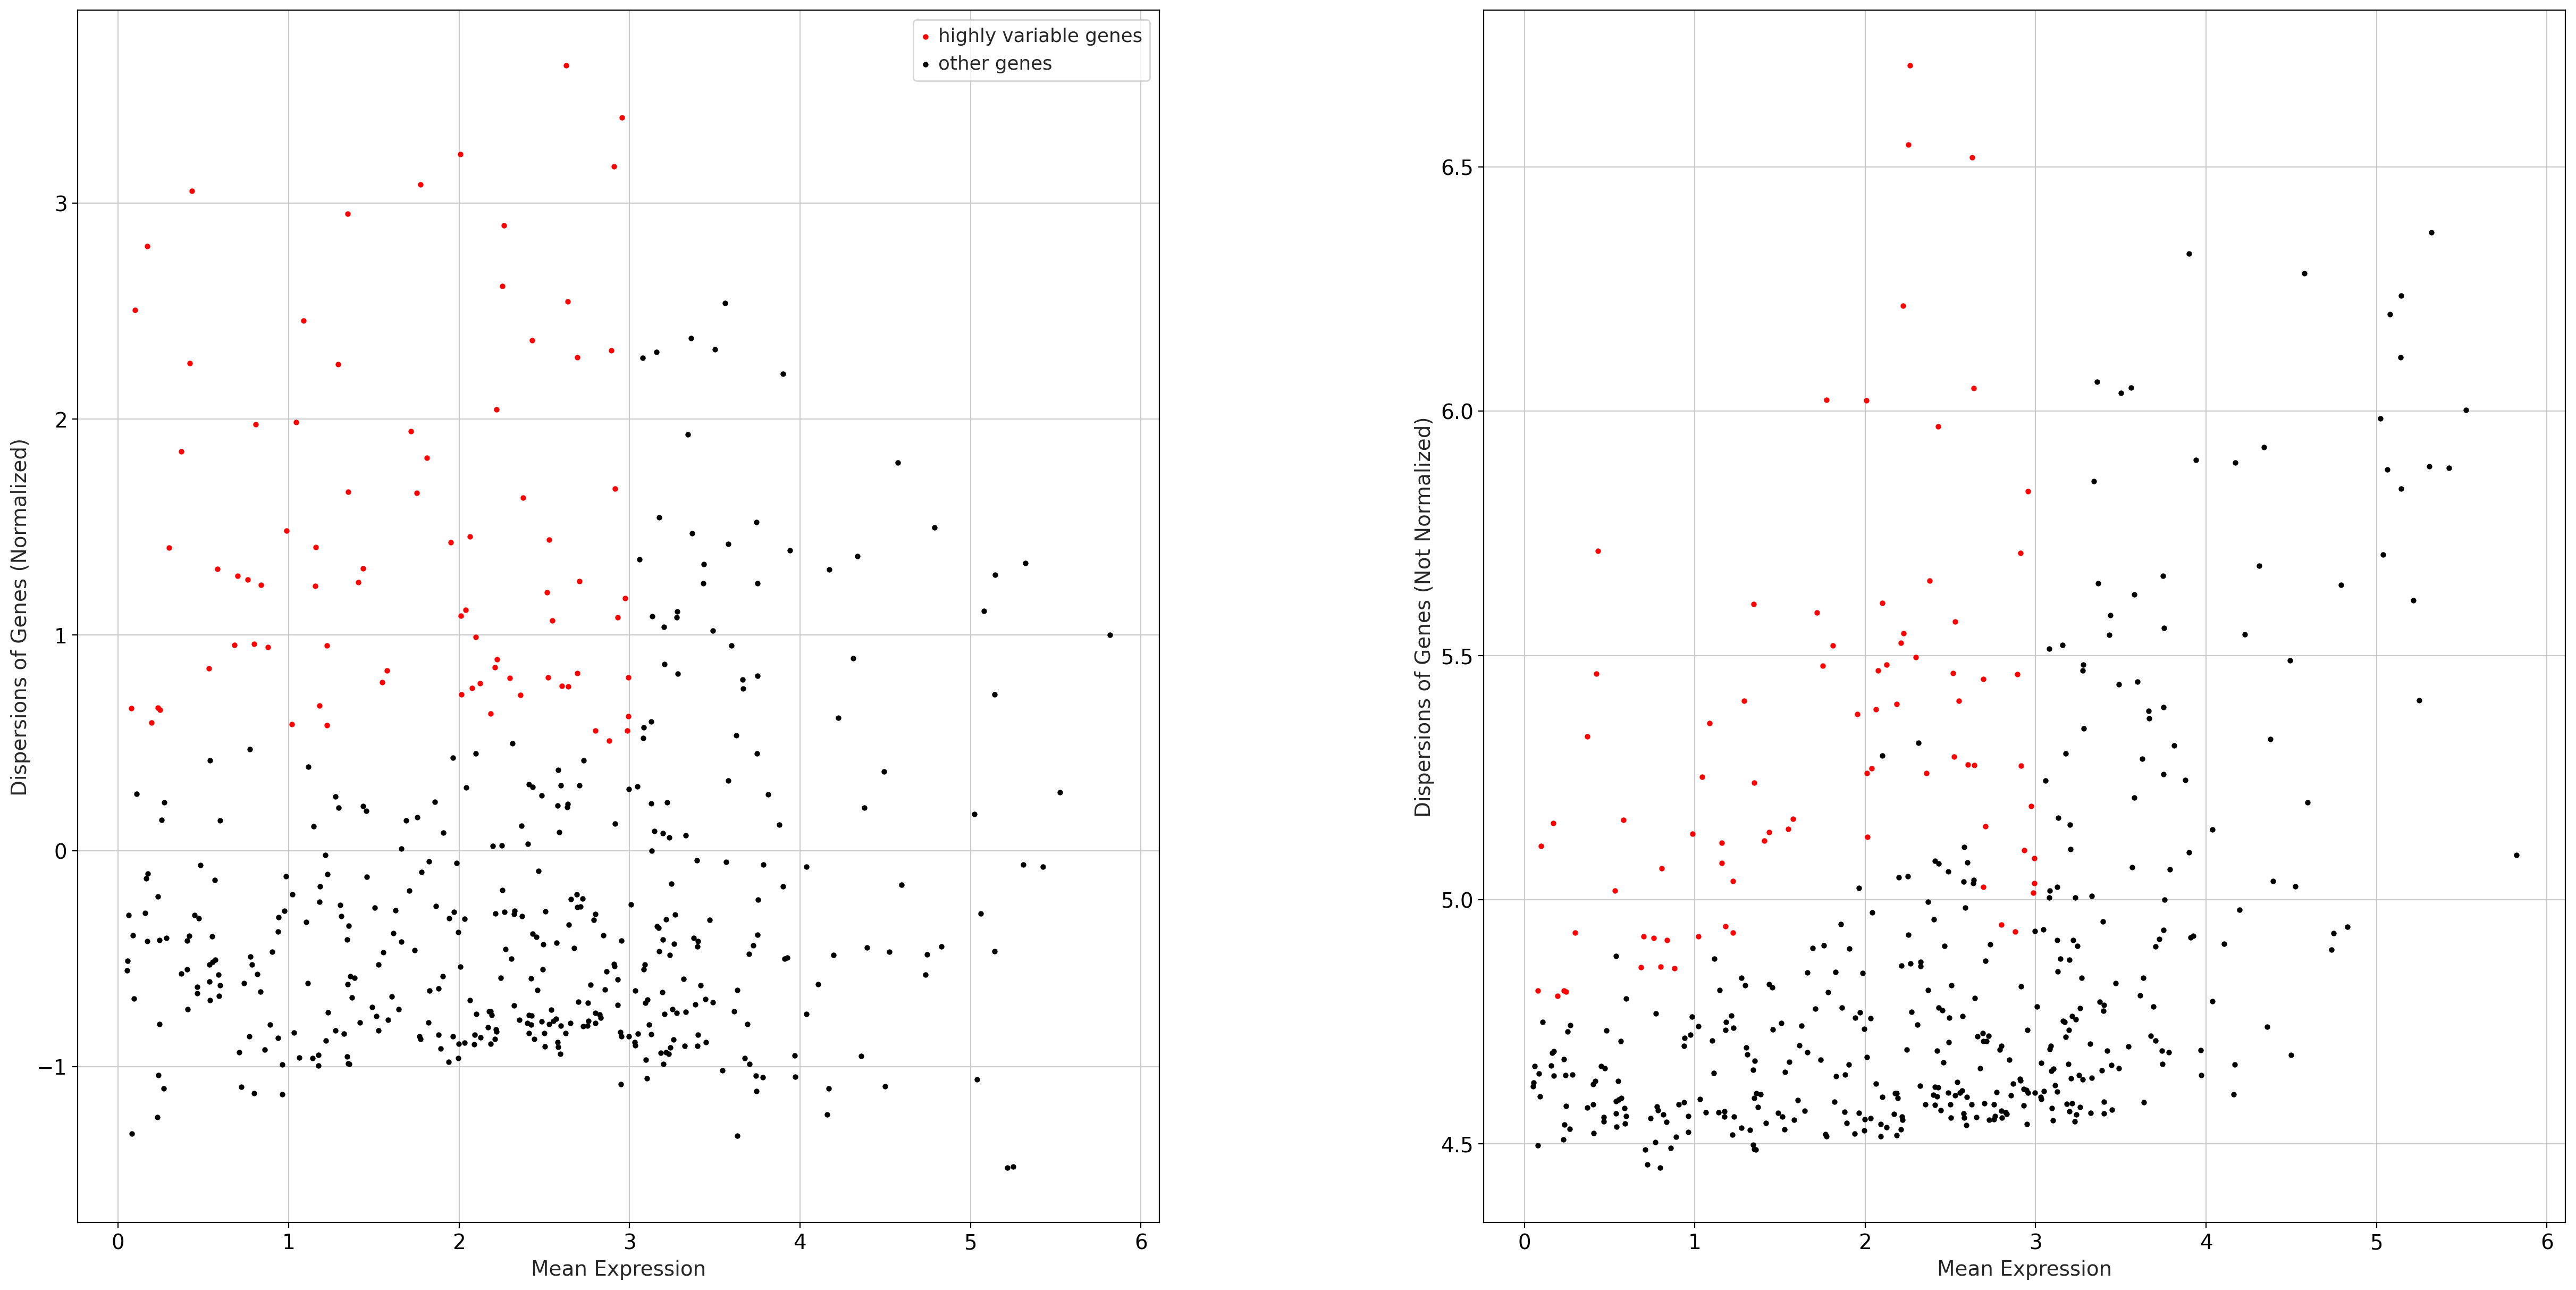


<<< NORMALIZING RAW GENE EXPRESSION >>>

	*** Scaling gene expression...

	*** Clipping maximum GEX SD to 10...

	*** Scaling => `.X` & scaled layer...
dsfasfda AnnData object with n_obs × n_vars = 599115 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels', 'Sample', 'Sample ID', 'Patient', 'Status', 'Slide Id', 'Project', 'Location', 'Stricture', 'GRID ID', 'Inflamed', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease_Status', 'Date Collected', 'Date Sectioned', 'Date Hybridization', 'Storage 4c', 'Created By', 'Created', 'Storage Status', 'Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'out_file', 'Condition', 'file_path', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_c

In [3]:
%%time

print("\n\n", kws_pp, "\n\n")
for i, s in enumerate(selves):
    f_o = str(selves[i].rna.obs.out_file.iloc[0])

    # Preprocessing
    if load is False:
        _ = s.preprocess(**kws_pp, figsize=(15, 15))  # preprocess

    # Clustering at Different Resolutions & Minimum Distances
    for j, x in enumerate(kws_clustering):

        # Variables & Output Files
        print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}\n\n")
        cct, cca = f"leiden_{x}", f"label_{x}"  # Leiden & annotation columns
        annot = assign[[col_assignment[j]]]  # gene-annotation dictionary

        # Clustering, Markers, Annotation, & Writing Output
        if load is False:
            _ = s.cluster(**kws_clustering[x], key_added=cct, out_file=f_o)
        if load is False or f"rank_genes_groups_{cct}" not in s.rna.uns:
            _ = s.find_markers(col_cell_type=cct, kws_plot=False)  # DEGs
        if reannotate is True or load is False:  # annotate; Explorer files
            _ = s.annotate_clusters(annot, col_cell_type=cct,
                                    col_annotation=cca)  # annotate
            for c in [k for k in [cct, cca] if k in s.rna.obs]:  # Explorer
                s.write_clusters(out_dir, col_cell_type=c, overwrite=True,
                                 file_prefix=f"{s._library_id}__", n_top=True)

    # Write Final Object
    if load is False or reannotate is True and f_o is not None:
        s.write(f_o)

## Tangram Imputation

In [ ]:
%%time

if file_sc is not None:
    adata_sc = sc.read(file_sc)  # read whole tx'ome data for imputation
    if load is False:
        for i, s in enumerate(selves):
            out = s.impute(
                adata_sc.copy(), col_cell_type=col_cell_type_sc,
                mode="clusters", markers=None, plot=False, plot_density=False,
                plot_genes=None, col_annotation=col_tangram, out_file=None)
            out[0].write_h5ad(os.path.splitext(selves[
                0].rna.obs.out_file.iloc[0])[0] + "___tangram.h5ad")  # write
            s.write(s.rna.obs.out_file.iloc[0])
            s.write_clusters(out_dir, file_prefix=f"{s._library_id}___",
                             col_cell_type=col_tangram,
                             overwrite=True, n_top=True)
    s.plot_spatial(color=col_tangram)

## Plot Clusters

In [ ]:
for s in selves:
    s.plot_spatial(color=col_tangram)
    for j, x in enumerate(kws_clustering):
        _ = s.plot_spatial(color=[f"leiden_{x}",, f"label_{x}"])

# Analyze

## Centrality Scores

In [ ]:
%%time

for s in selves:
    s.calculate_centrality(n_jobs=sc.settings.n_jobs)

## Neighborhood Enrichment Analysis

In [ ]:
%%time

for s in selves:
    _ = s.calculate_neighborhood(figsize=(60, 30))

## Cell Type Co-Occurrence

In [ ]:
%%time

for s in selves:
    _ = s.find_cooccurrence(figsize=(60, 20), kws_plot=dict(wspace=3))

## Spatial Clustering

In [ ]:
for s in selves:
    cct = f"leiden_spatial_{list(kws_clustering.keys())[-1]}"
    _ = s.cluster_spatial(key_added=cct,
                          **kws_clustering[list(kws_clustering.keys())[-1]])
    _ = s.find_markers(col_cell_type=cct, kws_plot=False)
    _ = s.annotate_clusters(assign[[col_assignment[-1]]], col_cell_type=cct,
                            col_annotation=f"annotation_{cct}")
    for c in [cct, f"annotation_{cct}"]:
        s.plot_spatial(c)
        if out_dir is not None:
            s.write_clusters(out_dir, col_cell_type=c,
                             n_top=True, overwrite=True,
                             file_prefix=f"{s._library_id}___")
    if out_dir is not None:
        s.write(str(s.rna.obs.out_file.iloc[0]))

## Spatially-Variable Genes

In [ ]:
%%time

kws = dict(kws_plot=dict(legend_fontsize="large"), figsize=(15, 15))
for s in selves:
    _ = s.find_svgs(genes=15, method="moran", n_perms=10, **kws)

## Receptor-Ligand Interactions

In [ ]:
%%time

for s in selves:
    kss, ktt = None, None
    _ = s.calculate_receptor_ligand(
        col_condition=False, p_threshold=0.01, remove_ns=True,
        figsize=(30, 20), top_n=25, key_sources=kss, key_targets=ktt)
    # s.calculate_receptor_ligand_spatial()

## Cell Type Composition 

In [ ]:
for s in selves:
    s.run_composition_analysis()

## GEX

In [ ]:
for s in selves:
    s.plot_spatial(color=["TNF", "IL23", col_cell_type])

In [ ]:
_ = self.calculate_spatial_distance("LTi-like NCR+ ILC3", genes="CSF2RB")

In [ ]:
adata.X = adata.layers["counts"]
sq.tl.var_by_distance(
    adata, "LTi-like NCR+ ILC3", col_cell_type, library_key=col_sample_id,
    design_matrix_key="design_matrix", covariates=["Patient", "Inflamed"],
    metric="euclidean", spatial_key=self._spatial_key, copy=False)
sq.pl.var_by_distance(
    adata=adata, var=["CSF2RB", "CSF2RA", "IL7R"],
    anchor_key="LTi-like NCR+ ILC3",
    covariate="Inflamed")

# Workspace

## Manual Annotations

50452

## GEX

In [ ]:
for self in selves:
    self.update_from_h5ad(str(self.rna.obs.out_file.iloc[0]))

In [ ]:
# i = 0
# s = selves[i]
# s.update_from_h5ad(str(s.rna.obs.out_file.iloc[0]))
s.rna.obs.loc[:, f"leiden_{resc[i]}"] = s.rna.obs[
    f"leiden_{resc[i]}"].astype(str)
s.get_layer("counts", inplace=True)
print(np.mean(s.rna[s.rna.obs[f"leiden_{resc[i]}"] == "9"][:, "CD79A"].X > 0))
print(np.mean(s.rna[s.rna.obs[f"leiden_{resc[i]}"] == "9"][:, "CD79B"].X > 0))
print(np.mean(s.rna[s.rna.obs[f"leiden_{resc[i]}"] == "6"][:, "CD79A"].X > 0))
print(np.mean(s.rna[s.rna.obs[f"leiden_{resc[i]}"] == "6"][:, "CD79B"].X > 0))
print(np.mean(s.rna[s.rna.obs[f"leiden_{resc[i]}"] == "6"][
    :, "ADAMDEC1"].X > 0))

In [ ]:
for x in ["COL1A1", "PEG10", "RCN3"]:
    print(np.mean(s.rna[s.rna.obs[f"leiden_{resc[i]}"] == "10"][:, x].X > 0))

In [ ]:
for x in ["BMP5", "F3", "MMP11", "CCL8", "NPY", "CH25H"]:
    print(np.mean(s.rna[s.rna.obs[f"leiden_{resc[i]}"] == "15"][:, x].X > 0))

In [ ]:
for x in ["LGR5"]:
    print(np.mean(s.rna[s.rna.obs[f"leiden_{resc[i]}"] == "16"][:, x].X > 0))

In [ ]:
for x in ["CRIP2", "KCNA5", "LBH", "NET1", "PLN", "RERGL"]:
    print(round(np.mean(s.rna[s.rna.obs[f"leiden_{resc[i]}"] == "20"][:, x].X > 0) * 100, 0))

In [ ]:
for x in ["TPSAB1", "CMA1"]:
    print(np.mean(s.rna[s.rna.obs[f"leiden_{resc[i]}"] == "21"][:, x].X > 0))

In [ ]:
for x in ["GNLY", "GZMB"]:
    print(np.mean(s.rna[s.rna.obs[f"leiden_{resc[i]}"] != "23"][:, x].X > 0))

In [ ]:
for x in marker_genes_dict["Pericyte"]:
    print(int(100 * np.mean(s.rna[s.rna.obs[f"leiden_{resc[i]}"] == "25"][
        :, x].X > 0)), " vs. ", int(100 * np.mean(s.rna[s.rna.obs[
            f"leiden_{resc[i]}"] != "25"][:, x].X > 0)))

In [ ]:
comp = "2"
print(", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[
    f"leiden_{resc[i]}"] == "11"][:, x].X > 0))) + " vs. " + str(int(
        100 * np.mean(s.rna[s.rna.obs[f"leiden_{resc[i]}"] == comp][
            :, x].X > 0))) + "%" for x in ["COL4A1", "COL4A2", "DLC1"]]))
print(f"\n...compared to {comp}")

In [ ]:
print(", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[
    f"leiden_{resc[i]}"] == "9"][:, x].X > 0))) + " vs. " + str(int(
        100 * np.mean(s.rna[s.rna.obs[f"leiden_{resc[i]}"] != "9"][
            :, x].X > 0))) + "%" for x in [
                "ZBTB38", "IFNAR2", "SELENOM", "XBP1"]]))

In [ ]:
# Memory B
# Stricture-50452C___leiden_res0.75_dist0.3_npc30
i = -1
s = selves[i]
s.rna.obs.loc[:, f"leiden_{resc[i]}"] = s.rna.obs[
    f"leiden_{resc[i]}"].astype(float).astype(int).astype(str)
clid = "21"
comp = ["2", "16", "18"]
print(", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[
    f"leiden_{resc[i]}"] == clid][:, x].X > 0))) + " vs. " + str(int(
        100 * np.mean(s.rna[s.rna.obs[f"leiden_{resc[i]}"].isin(comp)][
            :, x].X > 0))) + "%" for x in [
                "GPR183", "HHEX", "INPP5D", "LRRK2"]]))
print(f"\n...compared to {comp}")

In [ ]:
# Naive B
# Stricture-50452C___leiden_res0.75_dist0.3_npc30
i = -1
s = selves[i]
s.rna.obs.loc[:, f"leiden_{resc[i]}"] = s.rna.obs[
    f"leiden_{resc[i]}"].astype(float).astype(int).astype(str)
clid = "21"
comp = ["2", "16", "18"]
print(", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[
    f"leiden_{resc[i]}"] == clid][:, x].X > 0))) + " vs. " + str(int(
        100 * np.mean(s.rna[s.rna.obs[f"leiden_{resc[i]}"].isin(comp)][
            :, x].X > 0))) + "%" for x in [
                "IRF1", "LNPEP", "PLAC8", "IFITM1"]]))
print(f"\n...compared to {comp}")

## CD34

In [ ]:
import matplotlib.pyplot as plt

gene = "CD34"
thr = np.arange(1, 15)  # thresholds
fig, axes = plt.subplots(1, len(selves))
for i, s in enumerate(selves):
    print(f"{s._library_id}: {np.sum(s.rna[:, gene].X > 0)} / {s.rna.n_obs}")
    a_x = axes[i].bar(thr, [np.sum(s.rna[:, gene].X >= i) for i in thr])
    axes[i].set_title(s._library_id)
    # for x in s.rna.obs[f"leiden_{resc[i]}"].unique():
    #     print(str(x) + ": " + np.mean(s.rna[s.rna.obs[
    #         f"leiden_{resc[i]}"] == x][:, "CD34"].X > 0))
fig.suptitle("Total Cells above Count Thresholds for CD34")

## CSF1/2

In [ ]:
for g in ["CSF1", "CSF2"]:
    print(f"\n\n{'=' * 80}\n{g}\n{'=' * 80}")
    for i, s in enumerate(selves):
        print(f"{s._library_id}: {np.sum(s.rna[:, g].X > 0)} / {s.rna.n_obs}")

## Aligned Images

In [ ]:
landmarks = ShapesModel.parse(
    np.array([[10556.699, 7829.764], [13959.155, 13522.025], [10621.200, 17392.116]]), geometry=0, radius=500
)
visium_sdata["visium_landmarks"] = visium_landmarks

xenium_landmarks = ShapesModel.parse(
    np.array([[9438.385, 13933.017], [24847.866, 5948.002], [34082.584, 15234.235]]), geometry=0, radius=500
)
xenium_sdata["xenium_landmarks"] = xenium_landmarks

In [ ]:
import spatialdata_io as sdio
from spatialdata.models import ShapesModel

fai = os.path.join(
    "~/corescpy/examples/data/spatial",
    "Stricture-50452C__P53Red_P16Green_DAPIBlue.ome.tif")
faa = os.path.join(
    "~/corescpy/examples/data/spatial",
    "Stricture-50452C__P53Red_P16Green_DAPIBlue_matrix.csv")

img = sdio.xenium_aligned_image(fai, faa)